# Exercise 7
## Fundamentals of Machine Learning, WiSe 20/21
### Authors: Catherine Knobloch, Elias Olofsson, Julia Siegl
    Version information:
        2021-02-12: v.1.0. First public release. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('image', cmap='gray')

from scipy.sparse import coo_matrix
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr
from scipy.sparse.linalg import spsolve

# Produce inline vector graphics
%config InlineBackend.figure_format = 'svg'

## 3. Kernelized Ridge Regression (10 pts)

In [2]:
def squared_exp_kernel(X1, X2, sigma, tau=None):
    '''
    Calculate the squared exponential kernel function 
    for feature set X1 and X2. 
    
    Parameters:
    -----------
    X1: np.array shape=(M,D)
        First feature set, M instances of D dimensions.
    X2: np.array shape=(N,D)
        Second feature set, N instances of D dimensions.
    sigma: float
        Standard deviation of the gaussian distribution.
    tau: float
        (Optional) regularization parameter.
    
    Returns:
    --------
    scipy.sparse.coo_matrix  shape=(M,N)
        Resulting kernel matrix of feature sets X1 and X2.
    '''
    # Get matrix shapes, assure compatible sizes. 
    M,D  = X1.shape
    N,D2 = X2.shape
    assert D == D2
    
    # To reduce RAM-requirements, we chose a list-based methods of saving 
    # interesting pixel pairs, instead of explicitly forming the full matrix 
    # with distances from all instances in X1 to all instances in X2.
    d1 = []; ix = []; iy = []
    
    # For each instance in X2, do 
    for i in range(N):        
        # Calculate squared distances from X2[i] to all instances in X1.
        dist = np.sqrt(np.sum((X1-X2[i])**2, axis=1)) # shape = (M,)
        
        # Filter out distant pixel pairs.
        mask = dist < 3*sigma
        
        # Append to lists.
        d1.append(dist[mask].astype('float32'))               # L2 distance
        ix.append(mask.nonzero()[0].astype('int32'))          # Index in x
        iy.append(i*np.ones_like(dist[mask]).astype('int32')) # Index in y
    
    # Concatenate to single vectors.
    dist = np.concatenate(d1)
    ix   = np.concatenate(ix)
    iy   = np.concatenate(iy)
        
    # Apply the gaussian functional form.
    weights = np.exp(-0.5*dist**2/sigma**2)
    
    # If regularization is chosen, add tau to the diagonal.
    if tau != None:
        weights += (ix == iy)*tau
    
    return coo_matrix((weights, (ix, iy)), shape=(M,N), dtype=np.float32)

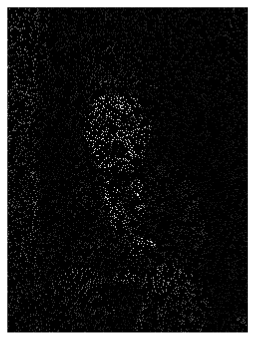

Shape: (338, 250)
Sparsity: 0.9


In [3]:
# Import the image.
im = plt.imread('cc_90.png')
plt.figure(figsize=(6,6))
plt.imshow(im)
plt.axis('off')
plt.show()

# Some info on the underlying sparse matrix.
im_shape = im.shape
print(f"Shape: {im_shape}")
print(f"Sparsity: {(im == 0).sum()/im.size}")

In [4]:
# Prepare the feature set, i.e. positions of the nonzero pixels.
(ix,iy) = im.nonzero()
X = np.array([ix,iy]).T
print(f'X.shape={X.shape}')

# Prepare the reponse vector, i.e. pixel values of non-zero pixels. 
y = im[ix,iy]
print(f'y.shape={y.shape}\n')

# Prepare the feature set of the missing pixels values.
(ix_zero, iy_zero) = (im == 0).nonzero()
X_new = np.array([ix_zero, iy_zero]).T
print(f'X_new.shape={X_new.shape}\n')

X.shape=(8450, 2)
y.shape=(8450,)

X_new.shape=(76050, 2)



In [5]:
def kernel_ridge_regression(X_new, X, y, sigma, tau):
    """
    Get predictions using Kernel Ridge Regression.
 
    Parameters:
    -----------
    X_new: np.array shape=(M,D)
        Feature matrix of test set.
    X: np.array shape=(N,D)
        Feature matrix of training set.
    y: np.array shape=(N,)
        Response vector of training set.
    sigma: float
        Standard deviation in squared exponential kernel function.
    tau: float
        Regularization parameter.
    
    Returns:
    --------
    y_new: np.array shape=(M,)
        Predicted responses corresponding to test set feature matrix X_new.
    """
    # Get the kernel matrix, with regularization.
    G_tau = squared_exp_kernel(X,X,sigma=sigma,tau=tau)
    
    # Convert to CSC sparse matrix format.
    G_tau = G_tau.tocsc()
    
    # Solve for the weight vector alpha.
    alpha = spsolve(G_tau, y)
    
    # Get kernel matrix for new instances X_new.
    kappa = squared_exp_kernel(X_new, X, sigma=sigma)
    
    # Calculate predicted responses.
    y_new = kappa.dot(alpha)
    
    return y_new

In [6]:
def construct_image(X_new, y_new, X, y, img_shape):
    """
    Reconstruct an image from feature matrices and response vectors.
    
    Parameters:
    -----------
    X_new: np.array shape=(M,D)
        Feature matrix of test set, containing pixel positions. 
    y_new: np.array shape=(N,)
        Response vector of test set, containing pixel values.
    X: np.array shape=(N,D)
        Feature matrix of training set, containing pixel positions.
    y: np.array shape=(N,)
        Response vector of training set, containing pixel values.
    
    Returns:
    --------
    img: np.array shape=img_shape
        The constructed image.
    """
    # Re-construct image
    img = np.zeros(img_shape)
    img[X[:,0],X[:,1]]         = y      # original pixels
    img[X_new[:,0],X_new[:,1]] = y_new  # predicted pixels
    return img

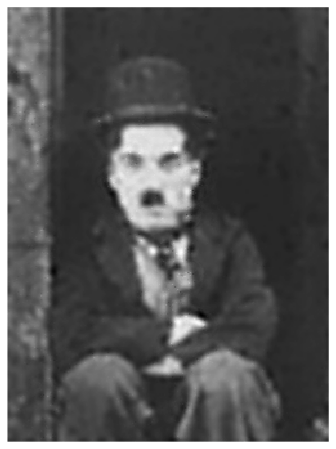

In [7]:
# Parameters
sigma = 3.5
tau   = 0.1

# Recontruct image using Kernal Ridge Regression
y_new = kernel_ridge_regression(X_new, X, y, sigma, tau)
img   = construct_image(X_new, y_new, X, y, im_shape)

# Plot the result
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.axis('off')
plt.show()

Hello there, Mr. Chaplin!

In [8]:
# Redo the reconstruction, for a wider range of parameters.
sigmas = [1, 2, 4, 8, 16]
taus   = [0.025, 0.05, 0.1, 0.25, 0.5, 1, 2]

# Loop through all parameter combinations, plot results.
fsize = (18,18)
fig, ax = plt.subplots(len(sigmas), len(taus), figsize=fsize,constrained_layout=True, sharex=True,sharey=True)
ax = ax.flatten()
for i, sigma in enumerate(sigmas):
    for j, tau in enumerate(taus):
        y_new = kernel_ridge_regression(X_new, X, y, sigma, tau)
        img   = construct_image(X_new, y_new, X, y, im_shape)
        ax[i*len(taus)+j].imshow(img)
        ax[i*len(taus)+j].axis('off')
        ax[i*len(taus)+j].set_title(f'$\\tau={{{tau}}} \quad \sigma={{{sigma}}}$')
plt.show()

The parameters that gives the visually best reconstruction of the image are $\tau \approx 0.1$ and $\sigma \approx 4$, as seen above. However, achieving a good result is a delicate balance on a knife's edge with the hyper-parameters. Slight modifications to any of the parameter values, in any direction, yields either a too pixelated, a too smooth or a too grainy image. For certain combinations, the solution even fails completely, and we get a gray wash-out of static noise.

In [9]:
def kernel_regression(X_new, X, y, sigma):
    """
    Get predictions using Nadaraya-Watson Kernel Regression.
    
    Parameters:
    -----------
    X_new: np.array shape=(M,D)
        Feature matrix of test set.
    X: np.array shape=(N,D)
        Feature matrix of training set.
    y: np.array shape=(N,)
        Response vector of training set.
    sigma: float
        Standard deviation in squared exponential kernel function.
    
    Returns:
    --------
    y_new: np.array shape=(M,)
        Predicted responses corresponding to test set feature matrix X_new.
    """
    # Get kernel matrix for new instances X_new.
    kappa = squared_exp_kernel(X_new, X, sigma=sigma)  # shape=(M,N)
    
    # Convert to CSC format.
    kappa = kappa.tocsc()
    
    # Get predictions.
    y_new = kappa.dot(y)/np.squeeze(np.asarray(kappa.sum(axis=1)))
    
    return y_new

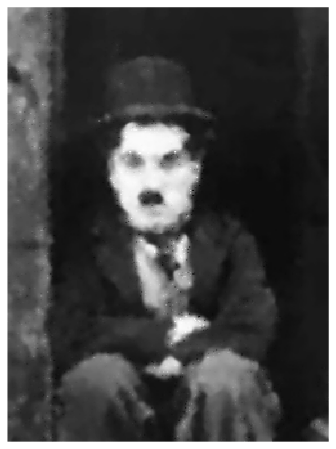

In [10]:
# Parameters.
sigma = 2

# Recontruct image using Kernal Regression.
y_new = kernel_regression(X_new, X, y, sigma)
img   = construct_image(X_new, y_new, X, y, im_shape)

# Plot the result.
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.axis('off')
plt.show()

With the Nadaraya-Watson Kernel Regression, we get an acceptable image reconstruction easier and quicker than with the full Kernel Ridge Regression. However, the quality of the reconstruction is not as high as with the Ridge-variant and a lot of fine details are smoothed out to a larger extent here. To my eye, the non-ridge kernel regression produced a reconstruction with a more "cartoony" feel than the kernel ridge regression, which instead felt more true to the original full resolution source image. I do think however that I prefer the non-ridge version, since it looks visually more pleasing with a larger contrast and less noise, even if it may be a less truthful representation of the original. 

<span style="color: green; font-weight: bold">Comments: In essence, our solution is rather similar to the given sample solution. Our code is not as short and concise, and our comments are perhaps sometimes leaning on the more exhaustive side rather than being minimalistic, but personally I thinks it helps with readbility. Otherwise, our visual comparison for different sigmas and taus for the kernel ridge regression is more extensive than in the sample solution, but on the other hand, we also gave a non-existent comparsion for the non-ridge regression, which we definitely could have done better, by explicitly showing the results for different sigmas.</span>